Evaluation Metrics for Classification
Use the same data as in the previous session: Churn Prediction (Identify clients that want to leave the company)
Data https://www.kaggle.com/blastchar/telco-customer-churn
Review of previous Session
Metrics: A function, that compares the actual values with the predicted values. It outputs a single number that measures the goodness of the model

4.1 Evaluation metrics: session overview
Setup

In [80]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

In [81]:
# Load DAta
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df= pd.read_csv(data)
df.head()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [82]:
# Data Preparation
#unify column names

df.columns= df.columns.str.lower().str.replace(" ",'_')
# df.columns

# List of all categorical columns
categorical_columns= list(df.dtypes[df.dtypes==object].index)
# categorical_columns

# Unify categorical columns

for c in categorical_columns:
    df[c]= df[c].str.lower().str.replace(' ','_')
# categorical_columns
    
# Change "totalcharges to numeric and fill na with 0

df['totalcharges']= pd.to_numeric(df['totalcharges'],errors='coerce')
df['totalcharges']= df['totalcharges'].fillna(0)
# df['totalcharges'].dtypes

# Change "churn" to type int; converts text labels ("yes"/"no") in the churn column into numeric form (1/0) so they can be used by ML algorithms.
df['churn']= (df['churn']=="yes").astype(int)

Model Setup

In [83]:
# 80% train + val = train_full, 20% test
df_fulltrain,df_test= train_test_split(df,test_size=0.2,random_state=1)
# 75% train, 25% val out of train_full 
# 60% train, 20% val, 20% test out of df
df_train,df_val= train_test_split(df_fulltrain,test_size=0.25,random_state=1)
# len(df_fulltrain), len(df_test), len(df_val), len(df_train)

# reset index
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

#assign churn to target variables
y_train= df_train['churn']
y_test= df_test['churn']
y_val= df_val['churn']

# delete "churn from df_train, df_val, df_test (not from df)
del df_train['churn']
del df_test['churn']
del df_val['churn']

In [84]:
numerical=["tenure", "monthlycharges", "totalcharges"]
categorical= ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [85]:
from sklearn.linear_model import LogisticRegression
# First convert to dictionary
train_dicts= df_train[categorical+numerical].to_dict(orient='records')
   
dv= DictVectorizer(sparse= False)    # don't use sparse matrix
X_train= dv.fit_transform(train_dicts)    

# we only transform for validation not fit
val_dicts= df_val[categorical+numerical].to_dict(orient='records')
X_val= dv.transform(val_dicts)

model= LogisticRegression()
model.fit(X_train,y_train)



c:\Users\snigd\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Predictions

In [86]:
y_pred= model.predict_proba(X_val)[:,1]  #gives you the predicted probabilities that each customer will churn. y_pred = [0.9, 0.2, 0.7, 0.1]
churn_decision= (y_pred>0.5)  #converting those probabilities into binary decisions: churn_decision = [True, False, True, False]
# (y_pred == churn_decision).mean()
(y_val == churn_decision).mean() #compare your predictions (churn_decision) with the actual labels (y_val), not with the probabilities:

np.float64(0.8026969481902059)

4.2 Accuracy and Dummy Model
Evaluate the model on different thresholds
Check the accuracy of the dummy baseline

In [87]:
# How many validation values do we have?
len(y_val)

1409

In [88]:
# How many correct decisions did we take?
(y_val==churn_decision).sum()

np.int64(1131)

In [89]:
# Accruracy: Correct Prediction / All Predictions
1131/1409

0.8026969481902059

In [90]:
# Is the threshold of 0.5 good?
# Test the model with different thresholds

threshold= np.linspace(0,1,21) #Creates 21 threshold values from 0 to 1
threshold

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [91]:
#Creates an empty list for scores

scores= []

# Loops through threshold values
for t in threshold:
    churn_decision= (y_pred>t)                                        #Converts probabilities to 0/1 predictions
    score = (y_val==churn_decision).mean()                            #Calculates accuracy for each threshold
    print(f"threshold: {t:.2f}, scores: {score:.3f}")                 #Prints results
    scores.append(score)                                              #Stores results for plotting later

threshold: 0.00, scores: 0.274
threshold: 0.05, scores: 0.509
threshold: 0.10, scores: 0.591
threshold: 0.15, scores: 0.666
threshold: 0.20, scores: 0.710
threshold: 0.25, scores: 0.739
threshold: 0.30, scores: 0.760
threshold: 0.35, scores: 0.772
threshold: 0.40, scores: 0.785
threshold: 0.45, scores: 0.793
threshold: 0.50, scores: 0.803
threshold: 0.55, scores: 0.801
threshold: 0.60, scores: 0.795
threshold: 0.65, scores: 0.786
threshold: 0.70, scores: 0.766
threshold: 0.75, scores: 0.744
threshold: 0.80, scores: 0.735
threshold: 0.85, scores: 0.726
threshold: 0.90, scores: 0.726
threshold: 0.95, scores: 0.726
threshold: 1.00, scores: 0.726


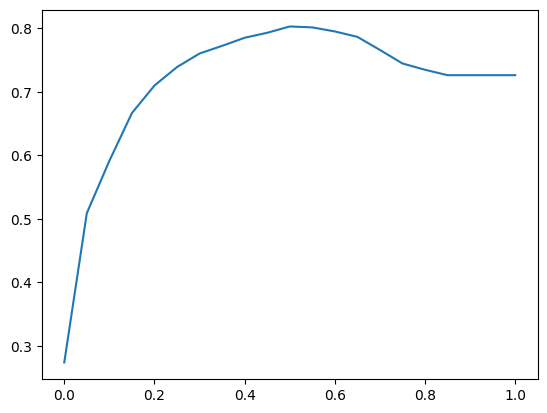

In [92]:
import matplotlib.pyplot as plt
plt.plot(threshold,scores);

# On the left, low thresholds → model says “churn” too often → low accuracy.

# Around 0.5, it’s balanced → accuracy peaks.

# On the right, high thresholds → model says “churn” too rarely → accuracy drops again.

Here 0.5 is the best threshold, before and afterwards the accuracy is lower
Scikit-learn provides a function for the accuracy (we wrote our own function above )

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val,(y_pred>0.5))

0.8026969481902059

In [94]:
# Special cases: threshold = 0 and threshold = 1
# threshold = 1 means, we are predicting that no customer is churning
# For this case (Dummy Model) the accuracy is ~73%
# threshold = 0 means, we are predicting that all customers are churning
# Our model gives an accuracy of 0.8

# non-churning users
1-y_val.mean()

np.float64(0.7260468417317246)

In [95]:
# In this data set that are much more non-churning than churning users
# We have class imbalance in this data set
# # For class imbalance, predicting the majority class already gives quite good accuracy and accuracy can be a misleading metric

4.3 Confusion Table
Different types of errors and correct decisions
Arranging them in a table


|                          | **Predicted: No Churn (0)** | **Predicted: Churn (1)** |
| ------------------------ | --------------------------- | ------------------------ |
| **Actual: No Churn (0)** | ✅ True Negative (TN)        | ❌ False Positive (FP)    |
| **Actual: Churn (1)**    | ❌ False Negative (FN)       | ✅ True Positive (TP)     |


In [96]:
# Step 1️ — Define actual classes
# actual_positive means customers who actually churned ; actual_negative means customers who actually stayed

actual_positive= (y_val==1)
actual_negative= (y_val==0)

In [116]:
# Step 2️. — Define predicted classes
# You use a threshold t = 0.5; If probability ≥ 0.5 → predict churn (1);If probability < 0.5 → predict not churn (0)

t = 0.5
predict_positive= (y_pred>=t)
predict_negative= (y_pred<t)

In [ ]:
# # y_pred[:10]
# print(predict_positive.sum(), predict_negative.sum())
# print(actual_positive.sum(), actual_negative.sum())


386 1023
386 1023


In [117]:
# <!-- Step 3️ — Count each case -->

tp =(predict_positive & actual_positive).sum()     #True Positives – correctly predicted churners
tn= (predict_negative & actual_negative).sum()     #True Negatives – correctly predicted non-churners
fp= (predict_positive & actual_negative).sum()     #False Positives – predicted churn but they didn’t churn
fn= (predict_negative & actual_positive ).sum()    #False Negatives – predicted no churn but they churned

tp,fp,tn,fn

(np.int64(210), np.int64(102), np.int64(921), np.int64(176))

In [118]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix


array([[921, 102],
       [176, 210]])

In [119]:
# Step 7️ — Relative numbers
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [101]:
# The confusion matrix helps you see where your model makes mistakes. It’s the foundation for precision, recall, and F1-score calculations.
# In business terms → helps balance between catching churners vs avoiding unnecessary offers.

4.4 Precision and Recall

In [120]:
# Accuracy
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8026969481902059)

In [121]:
# Precision: Fraction of positive predictions that are correct
tp / (tp + fp)

np.float64(0.6730769230769231)

In [122]:
# Recall: Fraction of correctly identified positive examples
# tp / (tp + fn) = tp / #positive observations
r = tp / (tp + fn)
r

np.float64(0.5440414507772021)

In [123]:
# | Metric        | Meaning                                              | Example (Churn Context)             |
# | ------------- | ---------------------------------------------------- | ----------------------------------- |
# | **Accuracy**  | How often predictions are right overall              | 80% customers correctly predicted   |
# | **Precision** | Of those predicted to churn, how many actually churn | 67% true churners, 33% false alarms |
# | **Recall**    | Of actual churners, how many did we catch            | Missed 46% of churners              |
# High precision, low recall → safe but misses many churners.
# High recall, low precision → catches most churners, but many false alarms.

4.5 ROC Curves
 TPR and FPR

In [124]:
# We want to see how well our model separates two classes (like churn vs. not churn) for different thresholds.
# It shows the trade-off between correctly predicting churners (True Positives) and accidentally flagging non-churners (False Positive

In [125]:
# TPR – True Positive Rate (Recall) ;Of all people who actually churned, how many did we correctly identify?
# TPR = 0.54 → 54% of real churners were correctly caught by the model.

tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [126]:
# FPR – False Positive Rate ;Of all people who didn’t churn, how many were wrongly marked as churners?
# FPR = 0.09 → 9% of non-churners were incorrectly flagged.

fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [127]:
# thresholds?

# Your model predicts probabilities (like 0.2, 0.8, etc.).
# You pick a threshold (say 0.5) to decide:

# if > 0.5 → predict churn (1)

# else → predict no churn (0)

# Changing the threshold changes how strict or lenient the model is.

# 📈 ROC Curve shows how TPR and FPR change when you test all possible thresholds (from 0 → 1).

In [138]:
# Calculate metrics for all thresholds
scores = []
threshold=  np.linspace(0,1,101)

for t in threshold:
    actual_positive= (y_val==1)
    actual_negative= (y_val==0)
    
    predict_positive= (y_pred>=t)
    predict_negative= (y_val<t)
    
    tp= (predict_positive & actual_positive).sum()
    tn= (predict_negative & actual_negative).sum()
    fp= (predict_positive & actual_negative).sum()
    fn= (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
    # Here, for each threshold t, we count how many are TP, FP, FN, TN, and store them.


In [140]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# Optional: add rates
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores.head()


,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.0,1.000000
1,0.01,385,914,0,1023,1.0,0.471864
2,0.02,384,830,0,1023,1.0,0.447922
3,0.03,383,766,0,1023,1.0,0.428172
4,0.04,381,715,0,1023,1.0,0.411392


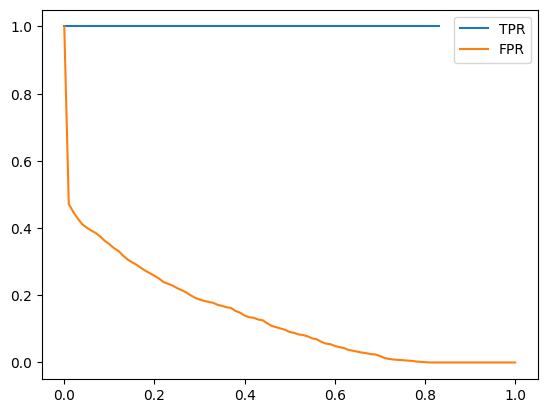

In [141]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")
plt.legend();

Random Model

In [142]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02], shape=(1409,))

In [143]:
# Accuracy of random model
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [144]:
# write tpr, fpr into dtaframe
# as previous code, but in a function
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))
        
    columns =["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
        
    df_scores["tpr"] = df_scores.tp/(df_scores.tp + df_scores.fn)
    df_scores["fpr"] = df_scores.fp/(df_scores.fp + df_scores.tn)
    
    return df_scores

In [145]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

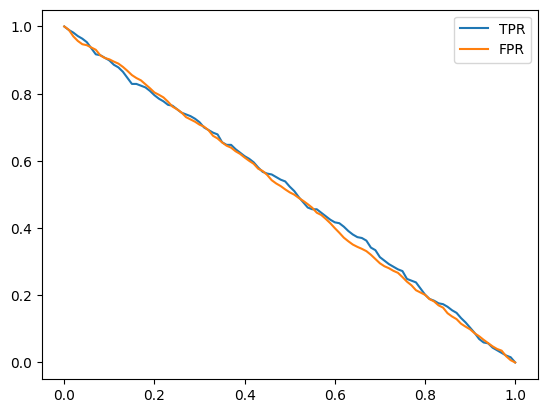

In [146]:
plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")
plt.legend();

Ideal Model

In [147]:
# All predictions are correct
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [148]:
# create ideal validation set
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [149]:
# create predictions (numbers between 0 and 1)
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [150]:
# accuracy of ideal model
# 72.6 of the customers are not churning
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [152]:
df_ideal =  tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.0,1.000000
1,0.01,386,1008,0,15,1.0,0.985337
2,0.02,386,994,0,29,1.0,0.971652
3,0.03,386,980,0,43,1.0,0.957967
4,0.04,386,966,0,57,1.0,0.944282


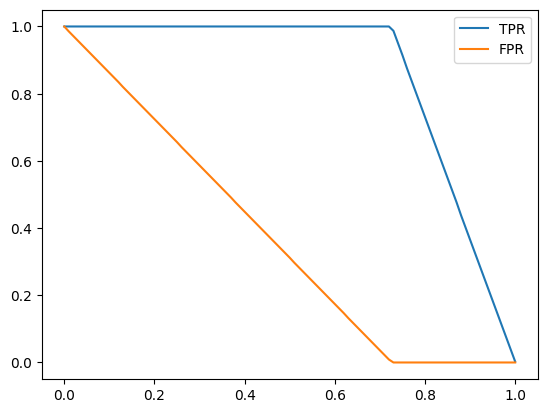

In [153]:
plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR")
plt.legend();

In [ ]:
# cut at threshold 0.726
# TPR is maximized and FPR is minimized for this threshold
# Such an ideal moel does not exist in reality, but it helps us to see how good our model is

Putting everything together

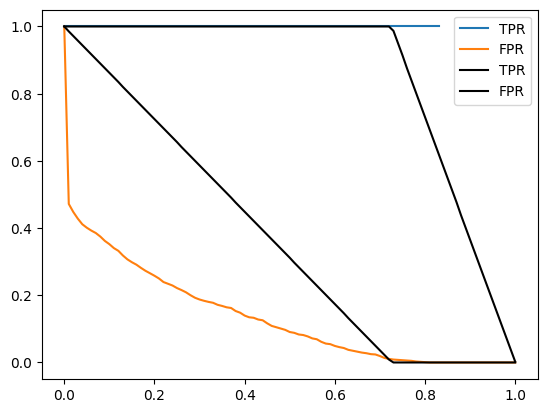

In [154]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")

#plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
#plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")

plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR", color="black")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR", color="black")
plt.legend();

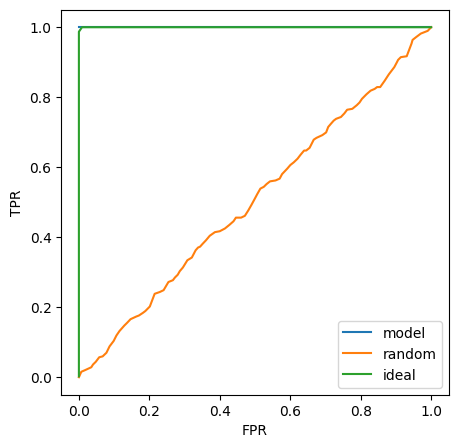

In [155]:
# These two models have different thresholds
# Compare TPR and FPR

plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot(df_rand.fpr, df_rand.tpr, label="random")
plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

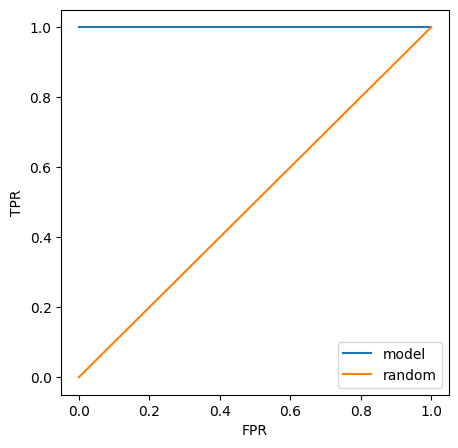

In [156]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr, df_scores.tpr, label="model")
plt.plot([0, 1], [0,1], label="random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

In [157]:
# We can use sklearn to plot the ROC curve

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

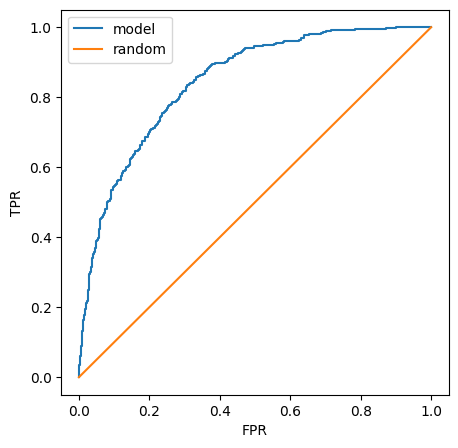

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label="model")
plt.plot([0, 1], [0,1], label="random")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend();

# The differences occur, because our evaluation was only for 101 thresholds and sklearn is more accurate

ROC AUC

In [ ]:

# Area under the ROC curve - useful metric for binary classification
# For the random model, thes area under the curve is AUC=0.5
# For the ideal model, thes area under the curve is AUC=1
# I.e. for all models AUC is between 0.5 and 1
# Getting the average prediction and the spread within predictions
# We can use sklearn to calculate AUC

In [159]:
from sklearn.metrics import auc
# for the scores calculated by sklearn
auc(fpr, tpr)

0.8438555705812935

In [160]:
# for our manually calculateds scores
auc(df_scores.fpr, df_scores.tpr)

nan

In [161]:
# for the ideal model
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [162]:
# This calculation can also be done in one step, directly from the validations and predictions
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438555705812935

In [163]:
# The above line is a shortcut for:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438555705812935

In [164]:
# AUC Interpretation:tells us, what the propabilty is of a randomly selected positive sample has a higher score than a randomly selected negative sample

# scores for negative samples
neg = y_pred[y_val==0]
# scores for positive samples
pos = y_pred[y_val==1]

In [165]:
# randomly select a positive sample
import random

pos_ind = random.randint(0, len(pos) -1)
neg_ind = random.randint(0, len(neg) -1)

In [166]:
# compare the scores of the positive and negative sample
pos[pos_ind] > neg[neg_ind]

np.False_

In [167]:
# Do this many times ...
n = 10000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success += 1
        
success/n

0.8521

In [168]:
# alternative vectorized implementation
n = 50000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [169]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84472)

Cross Validation

In [170]:
# Evaluating the same model on different subsets of data
# Getting the average prediction and the spread within predictions

# train a model
def train(df, y_train):
    dicts = df[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver="liblinear")
    model.fit(X_train, y_train)
    
    return dv, model

In [171]:
dv, model = train(df_train, y_train)

In [172]:
# make predictions 
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [ ]:
# To do the k-fold split we can use sklearn
!pip install tqdm

In [175]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

c:\Users\snigd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [181]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
# kfold.split(df_train_full) generates an iterator with indices for training and validation

In [182]:
train_idx, val_idx = next(kfold.split(df_fulltrain))

In [183]:
print(f"full data length: {len(df_fulltrain)}, train data length: {len(train_idx)}, validation data length {len(val_idx)}")

full data length: 5634, train data length: 5070, validation data length 564


In [184]:
# Loop through different folds
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_fulltrain)):
    df_train = df_fulltrain.iloc[train_idx]
    df_val = df_fulltrain.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    roc_auc = roc_auc_score(y_val, y_pred)
    scores.append(roc_auc)

10it [00:01,  7.90it/s]


In [185]:
scores

[0.8493392490816277,
 0.8420018564356436,
 0.8590269587894291,
 0.8330260883877869,
 0.8242710918114144,
 0.840959040959041,
 0.8437154021491371,
 0.8223513598987982,
 0.8445679561286498,
 0.8611811367685119]